#  Прогнозирование заказов такси

## Постановка задачи

Заказчиком является таксопарк, которая хочет, чтобы на основе их исторических данных о заказах такси в аэропортах обучили модель, которая бы прогнозировала количество заказов такси на следующий час.
Проверка модели должна осуществлятся на метрике RMSE. На тестовой выборке данная метрика должна быть не больше 48.

## Описание данных

- **taxi.csv** - данные, хронящие в себе колличество заказов

## План работы

**1) Подготовка**

- Установить индекс таблицы равным столбцу, содержащем в себе временные отрезки
- Узнать рамер данных
- Провести ресемплирование

**2) Анализ**

- Изучить распределение заказов на всем временном промежутке
- Добавить и изучить скользящее среднее и стандартное отклонение
- Разложить кол-во заказов на три составляющие: тренд, сезонность и остаток и изучить их

**3)Обучение моделей**

- 

## 1 Подготовка

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
import numpy as np

In [2]:
data = pd.read_csv(r'C:\Users\Илья\Downloads\taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.index.is_monotonic_increasing

True

In [5]:
data = data.resample('1H').sum()

In [6]:
data.shape

(4416, 1)

In [7]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


# Вывод

- Размер данных 26496 на 1
- Индексы идут попорядку
- Была произведена повторная выборка с новым интервалом в 1 час

## 2 Анализ

Посмотрим распределение заказов на всем отрезке времени, а так же построим графики для скользящего среднего и стандартного отклонения

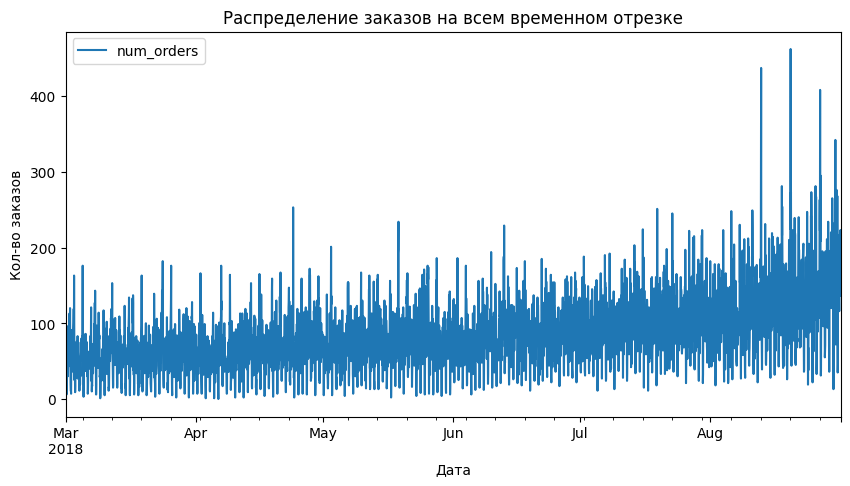

In [8]:
data.plot(figsize=(10,5))
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.title('Распределение заказов на всем временном отрезке');

In [9]:
data_ = data.copy()
data_['rolling_mean'] = data_['num_orders'].rolling(10).mean()
data_['std'] = data_['num_orders'].rolling(10).std()
data_ = data_.dropna()

Для удобства анализа скопировали данные

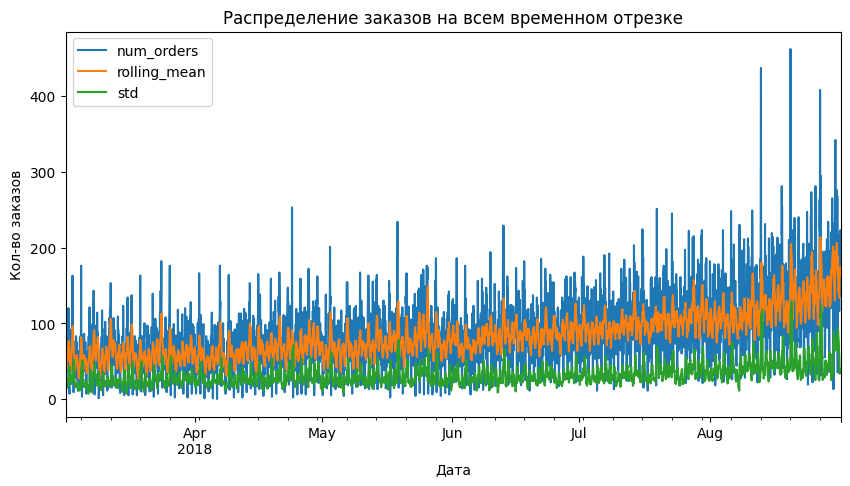

In [10]:
data_.plot(figsize=(10,5))
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.title('Распределение заказов на всем временном отрезке');

In [11]:
data_.head()

,num_orders,rolling_mean,std
datetime,,,
2018-03-01 09:00:00,69,52.5,37.426224
2018-03-01 10:00:00,64,46.5,28.414589
2018-03-01 11:00:00,96,47.6,30.225817
2018-03-01 12:00:00,30,43.5,29.470324
2018-03-01 13:00:00,32,40.1,28.532438


In [12]:
decomposed = seasonal_decompose(data_['num_orders'])

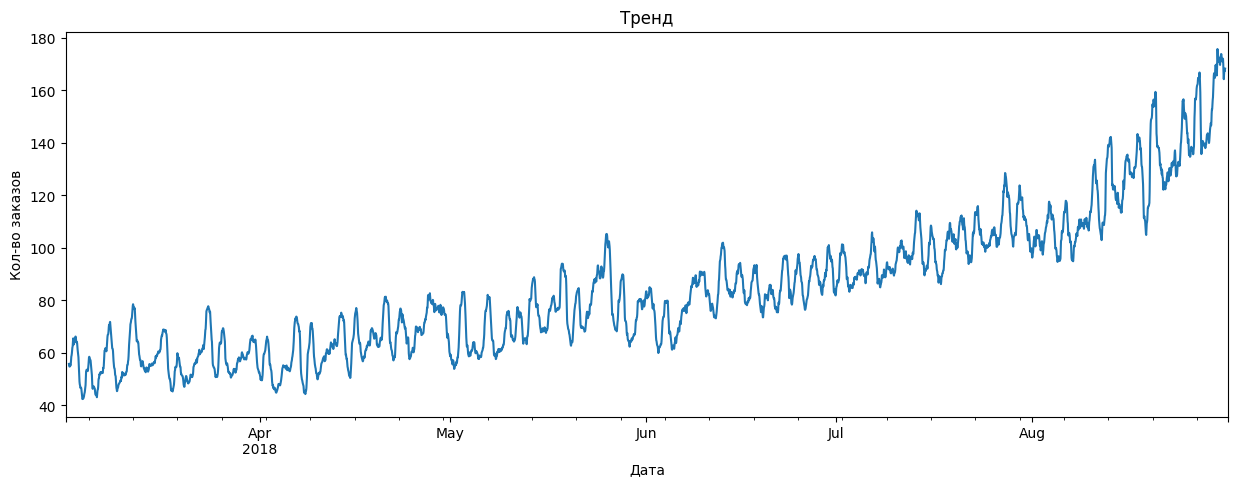

In [13]:
decomposed.trend.plot(title='Тренд', figsize=(15,5))
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов');

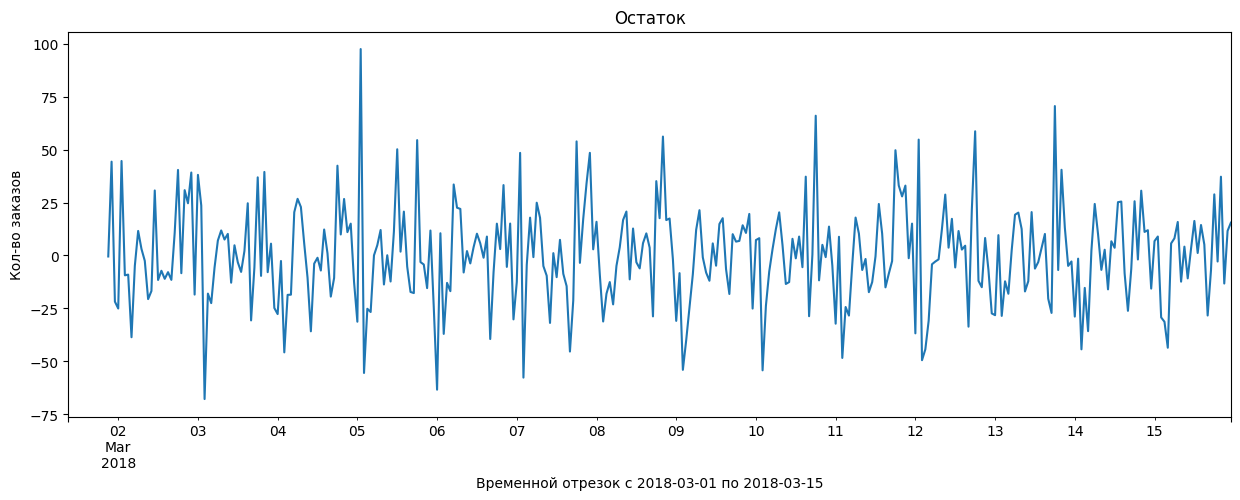

In [14]:
decomposed.resid['2018-03-01':'2018-03-15'].plot(title='Остаток', figsize=(15,5)) 
plt.xlabel('Временной отрезок с 2018-03-01 по 2018-03-15')
plt.ylabel('Кол-во заказов');

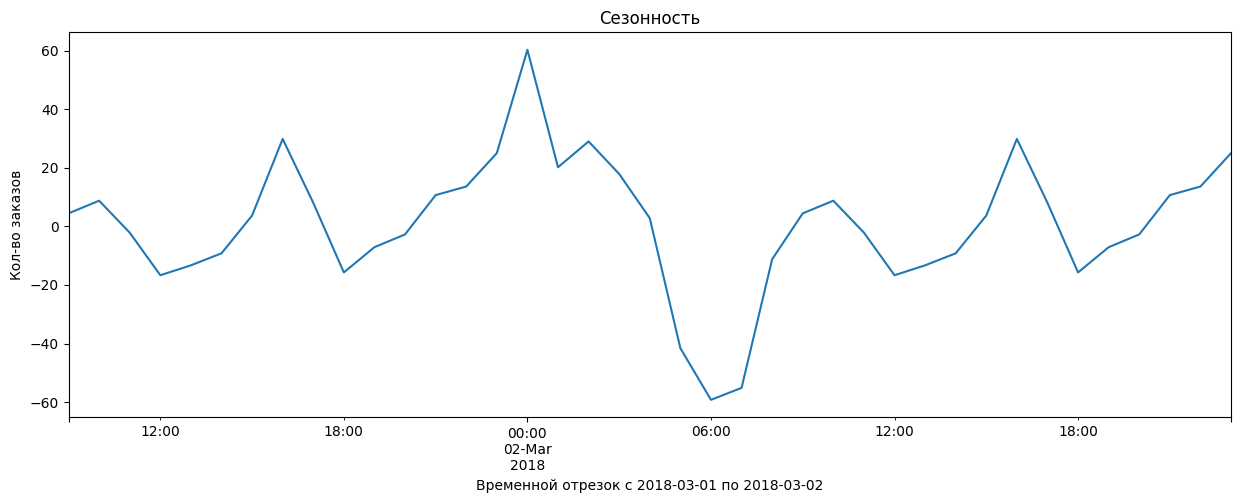

In [15]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(title='Сезонность', figsize=(15,5))
plt.xlabel('Временной отрезок с 2018-03-01 по 2018-03-02')
plt.ylabel('Кол-во заказов');

# Вывод

- Изучив график сезонности можно сказать, что он длится примерно 24 часа
- Сделав срез по графику сезоности в течении двух дней, было замечено что пик заказов приходится на 00:00. Скорее всего можно объяснить тем, что к этому времени общественный транспрот уже не ходит и при выборе вариата добраться из одной точки в другую выбирают такси
- Наименьше всего такси заказывают в 06:00. Такое колличество можно объяснить тем, что большинство людей спит в это время

## 3 Обучение моделей

Добавим календарные признаки, а так же вычислим отстающие значения 

In [16]:
def make_features(data, lag, rolling):
    data['hours'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for i in range(1, lag + 1):
        data['lag_{}'.format(i)] = data['num_orders'].shift(i)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling).mean()

make_features(data, 30, 20)

In [17]:
data.head()

,num_orders,hours,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
features = data.drop('num_orders', axis=1)
target = data['num_orders']


In [19]:
f_train, f_test, t_train, t_test = train_test_split(features, target,\
                                                    test_size=0.1, shuffle=False)
tscv = TimeSeriesSplit(n_splits=5)

In [20]:
f_train.shape, f_test.shape, t_train.shape, t_test.shape

((3974, 34), (442, 34), (3974,), (442,))

# CatBoostRegressor

In [21]:
%%time
model = CatBoostRegressor()
params = {
    'n_estimators': [600],
    'max_depth': [3], 
    'loss_function' : ['RMSE'],
    'random_state' : [12345]
}
grid_search = GridSearchCV(model, params, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(f_train, t_train, verbose=200)


print(grid_search.best_params_)
print(np.sqrt(np.abs(grid_search.best_score_)))

Learning rate set to 0.058136
0:	learn: 29.1440430	total: 139ms	remaining: 1m 23s
200:	learn: 14.1227516	total: 208ms	remaining: 413ms
400:	learn: 11.0369754	total: 265ms	remaining: 131ms
599:	learn: 8.8151811	total: 321ms	remaining: 0us
Learning rate set to 0.064849
0:	learn: 29.7071336	total: 14.7ms	remaining: 8.78s
200:	learn: 16.0420318	total: 84ms	remaining: 167ms
400:	learn: 13.5394301	total: 151ms	remaining: 75.1ms
599:	learn: 11.6545169	total: 218ms	remaining: 0us
Learning rate set to 0.069134
0:	learn: 31.1546572	total: 562us	remaining: 337ms
200:	learn: 17.1907246	total: 79.9ms	remaining: 159ms
400:	learn: 15.0280419	total: 158ms	remaining: 78.4ms
599:	learn: 13.5056356	total: 235ms	remaining: 0us
Learning rate set to 0.072346
0:	learn: 32.4154165	total: 686us	remaining: 411ms
200:	learn: 18.2420053	total: 91.6ms	remaining: 182ms
400:	learn: 16.1910713	total: 182ms	remaining: 90.3ms
599:	learn: 14.7051934	total: 273ms	remaining: 0us
Learning rate set to 0.074941
0:	learn: 33.

In [22]:
best_cat = grid_search.best_params_

# LGBMRegressor

In [23]:
%%time
model = LGBMRegressor()

param = {
    'n_estimators' : [1, 2, 5, 10],
    'objective' : ['RMSE']    
}

grid_lgb = GridSearchCV(model, param, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1)
grid_lgb.fit(f_train, t_train)

print(grid_lgb.best_params_)
print(np.sqrt(np.abs(grid_lgb.best_score_)))

{'n_estimators': 10, 'objective': 'RMSE'}
29.84166588816085
CPU times: total: 281 ms
Wall time: 1.54 s


In [24]:
best_lgb = grid_lgb.best_params_

# Вывод


- По результатам обучения  моделей для проверки была выбрана модель CatBoostRegressor. При параметрах **iterations: 600, max_depth: 3, loss_function: RMSE** она показала наилучшую метрику **RMSE: 24.8** 

## 4 Тестирование

In [25]:
%%time
model = CatBoostRegressor(**best_cat).fit(f_train, t_train, verbose=100)
predict = model.predict(f_test)
result_mse =  mean_squared_error(t_test, predict)
print('RMSE:', result_mse**0.5)

Learning rate set to 0.07713
0:	learn: 37.3857259	total: 761us	remaining: 456ms
100:	learn: 22.9375278	total: 61.4ms	remaining: 303ms
200:	learn: 21.0542573	total: 118ms	remaining: 235ms
300:	learn: 19.6792263	total: 174ms	remaining: 173ms
400:	learn: 18.7041487	total: 231ms	remaining: 115ms
500:	learn: 17.9297257	total: 286ms	remaining: 56.5ms
599:	learn: 17.2286825	total: 340ms	remaining: 0us
RMSE: 42.4892231327642
CPU times: total: 6.28 s
Wall time: 383 ms


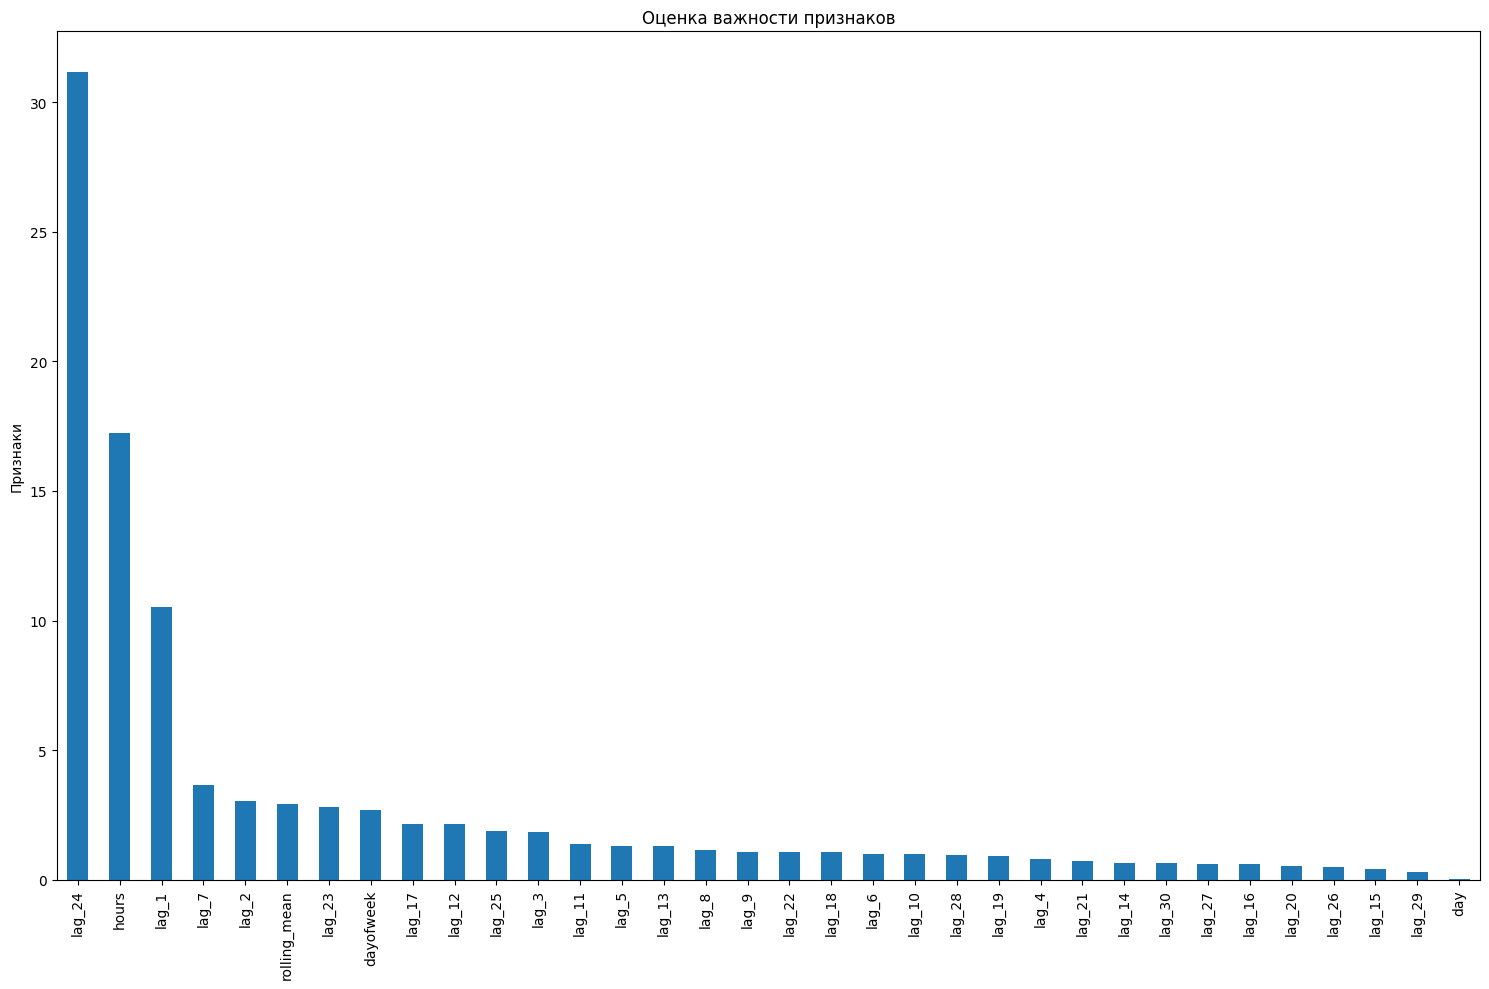

In [26]:
feature_imp = pd.Series(model.feature_importances_, index=f_test.columns).sort_values(ascending=False)
      
fig, ax = plt.subplots(figsize=(15,10))
feature_imp.plot.bar(ax=ax)
_ = ax.set_title('Оценка важности признаков')
_ = ax.set_ylabel('Признаки')
fig.tight_layout()

По графику важности признаков можно заметить, что наиболее важными для обучения модели являются признаки **hours** и **lag_24**. Для возможного улучшения метрики их нельзя удалять. Так же есть признаки которые не играют роль при обучении **day** и **lag_29**  их можно удалить и проверить повысится ли качество метрики

In [27]:
filt_features_train = f_train.copy()
filt_features_test = f_test.copy()
filt_features_train = filt_features_train.drop(columns=['day', 'lag_29'])
filt_features_test = filt_features_test.drop(columns=['day', 'lag_29'])

In [28]:
%%time
model = CatBoostRegressor(**best_cat).fit(filt_features_train, t_train, verbose=100)
predict = model.predict(filt_features_test)
result_mse =  mean_squared_error(t_test, predict)
print('RMSE:', result_mse**0.5)


Learning rate set to 0.07713
0:	learn: 37.3560317	total: 804us	remaining: 482ms
100:	learn: 22.9042075	total: 59.4ms	remaining: 294ms
200:	learn: 20.9080969	total: 111ms	remaining: 220ms
300:	learn: 19.5877278	total: 164ms	remaining: 163ms
400:	learn: 18.5817631	total: 218ms	remaining: 108ms
500:	learn: 17.8231174	total: 270ms	remaining: 53.3ms
599:	learn: 17.1666148	total: 321ms	remaining: 0us
RMSE: 41.64655147111678
CPU times: total: 5.86 s
Wall time: 362 ms


Как можно видеть качество метрики возросло с **42.5** до **41.65**

In [29]:
model = DummyRegressor(strategy="mean").fit(f_train, t_train)
pred = model.predict(f_test)
result_mse =  mean_squared_error(t_test, pred)
print('RMSE:', result_mse**0.5)

RMSE: 84.74414402014742


# Отчет

**1) Подготовка**

- Размер данных до ресемпилирования **26496 на 1** после **4416 на 1**
- Проверка индекс показала, что они идут по порядку
- Была произведена повторная выборка с новым интервалом в 1 час

**2) Анализ**

- Изучив график сезонности можно сказать, что она длится примерно 24 часа
- Сделав срез по графику сезоности в течении двух дней, было замечено что пик заказов приходится на 00:00. Скорее всего можно объяснить тем, что к этому времени общественный транспрот уже не ходит и при выборе вариата добраться из одной точки в другую выбирают такси
- Наименьше всего такси заказывают в 06:00. Такое колличество можно объяснить тем, что большинство людей спит в это время

**3) Обучение**

- По результатам обучения  моделей для проверки была выбрана модель CatBoostRegressor. При параметрах **iterations: 600, max_depth: 3, loss_function: RMSE** она показала наилучшую метрику **RMSE: 24.8**  

**4) Тестирование лучшей модели**

- При первой проверки модели значения **RMSE: 42.5**
- При построении графика оценки важности признаков было замечено, что наибольшую важность при обучении играет признак **lag_24** и **hours**
- Для улучшения качества модели было решено убрать малозначимые признаки. Проверка модели CatBoostRegressor на тестовых данных показала метрику **RMSE: 41.65**
- Была сделана проверка модели на адекватность при помощи константной модели. Показатели константной модели составили **RMSE: 84.74**. По результатам модель проходит проверку на адекватность

**Все пункты составленного плана были выполнены**

**Ключевые шаги**

- Правильный анализ данных
- Правильный подбор параметров для обучения модели
- Выбор значимых и не значимых признаков по графику важности

**Признаки используемые при обучении**

- hours, day, dayofweek, rolling_mean, lag_1 - lag_30

**Лучшая модель**

- Лучшая модель **CatBoostRegressor**
- Парметры **iterations: 600, max_depth: 3, loss_function: RMSE**
- Метрика **RMSE: 41.65**

***